<img src="JFM-notebooks-logo.jpg" style="max-width:100%" />

### Imports

In [3]:
import sys, os
os.environ['NOWARNINGS'] = '1'
sys.path.append(os.path.join('Code'))
from load_data import load_data
from postprocessing.plotting import *
plotting_defaults()
plt.rcParams['figure.dpi'] = 150 # to adjust display size in notebook
ref, refsim, transient, varsim_list = load_data('Data', include_ensemble=False)
textwidth = 5.31445

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from postprocessing.plotting import *
from matplotlib import gridspec

### Generate figure

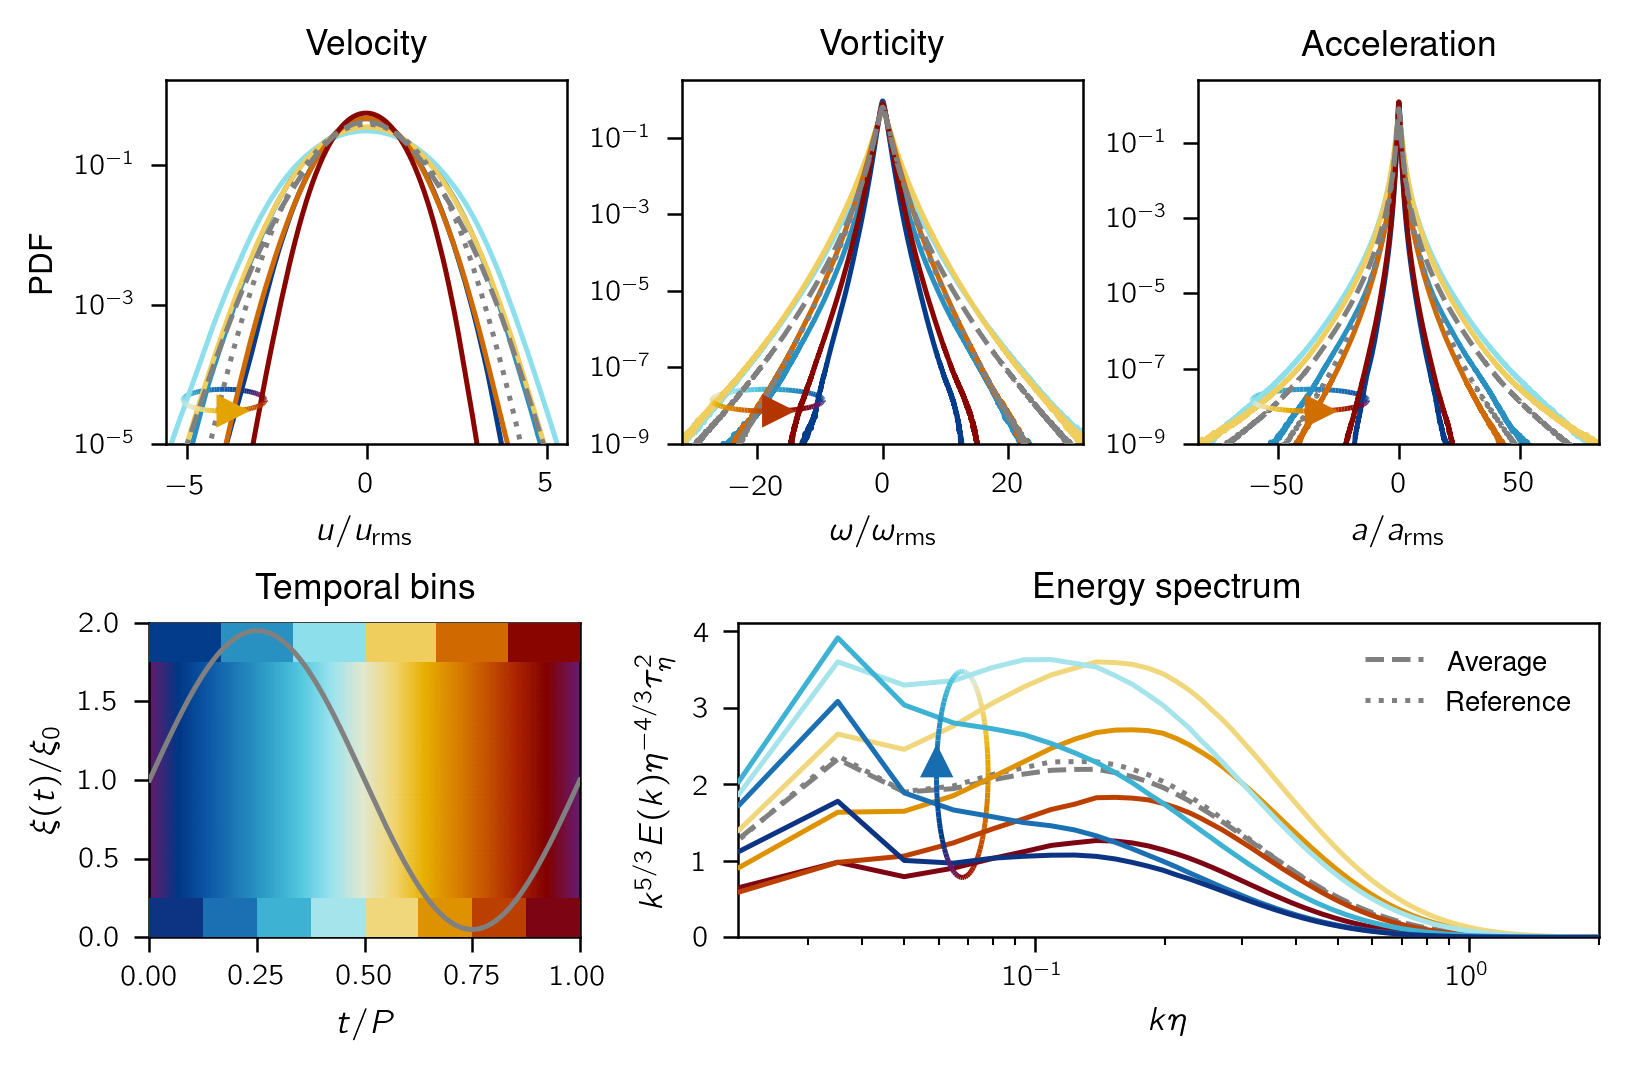

In [5]:
# select simulation (histograms for other simulations not available)
varsim = varsim_list[8]

# set up figure
plt.figure(figsize=(textwidth, 0.65*textwidth))
outer_grid = gridspec.GridSpec(2,1, figure=plt.gcf(), height_ratios=[1.1,1])
upper_grid = gridspec.GridSpecFromSubplotSpec(1,3, outer_grid[0,0])
lower_grid = gridspec.GridSpecFromSubplotSpec(1,2, outer_grid[1,0],width_ratios=[1,2])
axs = {}
axs['vel'] = plt.subplot(upper_grid[0,0])
axs['vort'] = plt.subplot(upper_grid[0,1])
axs['acc'] = plt.subplot(upper_grid[0,2])
axs['inj'] = plt.subplot(lower_grid[0,0])
axs['spec'] = plt.subplot(lower_grid[0,1])
axs['vel'].set_title('Velocity')
axs['vort'].set_title('Vorticity')
axs['acc'].set_title('Acceleration')
axs['spec'].set_title('Energy spectrum')
axs['inj'].set_title('Temporal bins')

## Plot of injection rate and color code
plt.sca(axs['inj'])
tfine = np.linspace(0, varsim.get_period(), 512)
plt.plot(tfine/varsim.get_period(),
         varsim.get_injection_rate(tfine)/ref.injrate,
         zorder=10, color='grey')

# color gradient
axs['inj'].imshow([[0,1],[0,1]], cmap=erdc_iceFire,
                  interpolation='bilinear', extent=(-0.5, 1.5, -0.5, 3.),
                  aspect='auto')

# visualize temporal bins
t_bins = varsim.get_tbins(8, minsize=0.)
t_bincenters = (t_bins[1:] + t_bins[:-1])/2
for tkey in range(len(t_bincenters)):
    plt.fill_between([t_bins[tkey]/varsim.get_period(), t_bins[tkey+1]/varsim.get_period()],
                     0, 0.25, zorder=5,
                     facecolor=erdc_iceFire((tkey+0.5)/len(t_bincenters)))
t_bins = varsim.get_tbins(6, minsize=0.)
t_bincenters = (t_bins[1:] + t_bins[:-1])/2
for tkey in range(len(t_bincenters)):
    plt.fill_between([t_bins[tkey]/varsim.get_period(), t_bins[tkey+1]/varsim.get_period()],
                     1.75, 2., zorder=5,
                     facecolor=erdc_iceFire((tkey+0.5)/len(t_bincenters)))

# range and labels
plt.xlim(0, 1)
plt.ylim(0, 2.)
plt.xlabel(r'$t/P$')
plt.ylabel(r'$\xi(t)/\xi_0$')

## energy spectrum plot
plt.sca(axs['spec'])
binno = 8
t_bins = varsim.get_tbins(binno, minsize=ref.tauK/2)
t_bincenters = (t_bins[1:] + t_bins[:-1])/2
vspec, meanvspec = varsim.periodic_spectrum(t_bins, transient)

# plot compensated spectra while collecting lines for circle
linesx = []
linesy = []
vspeccompensation = refsim.statistics['kshell'][:-2]**(5/3)*ref.etaK**(-4/3)*ref.tauK**2
for tkey, tbin in enumerate(t_bincenters):
    linesx.append(varsim.statistics['kshell'][:-2]*ref.etaK)
    linesy.append(vspec[tkey][:-2]*vspeccompensation)
    plt.plot(linesx[-1], linesy[-1],
            color=erdc_iceFire((tkey+0.5)/len(t_bincenters)),
            zorder = 50-tkey)

# plot time-averaged spectra of oscillating and reference simulation
plt.plot(varsim.statistics['kshell'][:-2]*ref.etaK,
         meanvspec[:-2]*vspeccompensation,
         color='grey', ls='--', label='Average')
plt.plot(refsim.statistics['kshell'][:-2]*ref.etaK,
        refsim.statistics['energy(k)'][:-2]*vspeccompensation,
        color='grey', ls=':', label='Reference')

# range and labels
plt.xlabel('$k \eta$')
plt.ylabel(r'$k^{5/3}E(k) \eta^{-4/3}\tau_\eta^2$')
plt.xscale('log')
plt.xlim(np.amin(varsim.statistics['kshell'][1:-2]*ref.etaK), 2e0)
plt.ylim(bottom=0)
plt.legend(frameon=False, loc='upper right')

# plot phase circle after range is fixed
plot_phase_circle(
    linesx, linesy, pos=0.26, cmap=erdc_iceFire, orientation = 'vertical')

## PDF plots
binno = 6
t_bins = varsim.get_tbins(binno, minsize=ref.tauK/2)
t_bincenters = (t_bins[1:] + t_bins[:-1])/2
for quantity in ['vel', 'vort', 'acc']:
    plt.sca(axs[quantity])
    if quantity == 'vel':
        plt.xlabel(r'$u / u_\mathrm{rms}$')
        plt.ylabel(r'PDF')
        unit = ref.velrms
    elif quantity == 'vort':
        unit = ref.vortrms
        plt.xlabel(r'$\omega / \omega_\mathrm{rms}$')
    elif quantity == 'acc':
        unit = ref.accrms
        plt.xlabel(r'$a / a_\mathrm{rms}$')

    q_bincenters, pdf_binned, pdf_mean = varsim.periodic_pdf(quantity, t_bins, transient)

    # plot time-averaged PDFs of oscillating and reference simulation
    plt.plot(q_bincenters/unit, pdf_mean*unit, label='Average',
        color='grey', ls='--', zorder=19)
    refvals = refsim.statistics[f'hist_{quantity}_bins']
    refpdf = refsim.statistics[f'hist_{quantity}_mean']
    plt.plot(refvals/unit, refpdf*unit, label='Reference',
        color='grey', ls=':', zorder=20)

    # plot PDFs while collecting lines for circle
    linesx = []
    linesy = []
    for tkey, tbin in enumerate(t_bincenters):
        linesx.append(q_bincenters[q_bincenters<0]/unit)
        linesy.append(pdf_binned[tkey][q_bincenters<0]*unit)
        plt.plot(q_bincenters/unit, pdf_binned[tkey]*unit,
            c=erdc_iceFire((tkey+0.5)/(len(t_bincenters))),
            label=r'$t \approx {}P$'.format(
                np.round(tbin/varsim.get_period(), 2)))

    # range and labels
    plt.yscale('log')
    if quantity == 'vel':
        plt.xlim(-5.57, 5.57)
        plt.ylim(bottom=1e-5)
    elif quantity == 'vort':
        plt.xlim(-32, 32)
        plt.ylim(bottom=1e-9)
    else:
        plt.xlim(-83, 83)
        plt.ylim(bottom=1e-9)

    # plot phase circle after range is fixed
    plot_phase_circle(
        linesx, linesy, pos=0.12, cmap=erdc_iceFire, orientation = 'horizontal')